In [1]:
import uproot3 as uproot
import uproot_methods
import uproot_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt
import time
import infofile
import numpy as np
import mplhep as hep
from scipy import stats
import boost_histogram as bh
import pandas as pd

In [2]:
samples = ["zzjj", "ttz", "twz"]

xsecs= [2530, 759, 115]

BR = [(0.034 + 0.034)**2,
      (0.034 + 0.034) * (0.11 + 0.11) * (0.11 + 0.11),
      (0.034 + 0.034) * (0.11 + 0.11) * (0.11 + 0.11)
      ]
#intLumi = 139.0
intLumi = 3000.0
n_events = 30000

In [3]:
n_exp = np.array([])
n_exp_cuts = np.array([])

plot_z_pt = []
plot_z_pt_true = []

plot_zpt_diff_xs = []
plot_zpt_diff_xs_true = []
plot_nbtag = []
plot_njet = []
plot_ht = []
plot_z_mass = []
plot_z_pt = []
plot_z_pt_true = []

bins_z_mass = np.linspace(60.0, 120.0, num=30)
bins_z_pt = np.linspace(0.0, 300.0, num=5)
bins_nbtag = np.linspace(-0.5, 5.5, num=7)
bins_njet = np.linspace(-0.5, 5.5, num=7)
bins_ht = np.linspace(0.0, 300.0, num=2)

for isample in range(0, len(samples)):

    n_mumu_cand = np.array([])
    mumu_cand_masses = np.array([])
    mumu_cand_pts = np.array([])

    n_elel_cand = np.array([])
    elel_cand_masses = np.array([])
    elel_cand_pts = np.array([])

    sample_name = str("delphes_output_") + str(samples[isample]) + str("_4l.root")
    eventsData = uproot.open(sample_name)["Delphes"] 
    eventsData.show()
    EventWeight, EventCrossSection, JetPT, JetEta, JetBTag, MuonPT, MuonEta,  MuonPhi,  MuonT, MuonCharge, MuonIsolationVar, MuonDZ, ElectronPT, ElectronEta,  ElectronPhi,  ElectronT, ElectronCharge, ElectronIsolationVar, ParticlePID, ParticleStatus, ParticleMass, ParticlePT = eventsData.arrays(["Event.Weight", "Event.CrossSection","Jet.PT", "Jet.Eta", "Jet.BTag", "Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.T", "Muon.Charge", "Muon.IsolationVar", "Muon.DZ", "Electron.PT", "Electron.Eta", "Electron.Phi", "Electron.T", "Electron.Charge", "Electron.IsolationVar", "Particle.PID", "Particle.Status","Particle.Mass", "Particle.PT"],outputtype=tuple)

    EventIDs = np.arange(0, len(EventCrossSection), 1, dtype=int) 
    
    evWeight = (xsecs[isample] * BR[isample] * intLumi)/n_events
   
    #object-level cuts
    e_cut  = (ElectronPT>10) & (ElectronIsolationVar<0.1) & ( abs(ElectronEta)< 4)
    mu_cut  = (MuonPT>10) & (MuonIsolationVar<0.1) & ( abs(MuonEta)< 4)
    jet_cut  = (JetPT>20) & (abs(JetEta)< 4.5)
    btag_cut  = (JetBTag==1)
    
    #event-level cuts    
    n_lep_cut = ( ( (ElectronPT[e_cut].counts) + (MuonPT[mu_cut].counts))== 4) 
    sum_charge_cut =  ((ElectronCharge[e_cut].sum()) + (MuonCharge[mu_cut].sum())==0 )
    njet_cut = (JetPT[jet_cut].counts >= 1)
    nbtag_cut = (JetPT[jet_cut & btag_cut].counts == 1)
    
    # flat event cut
    event_cut = (n_lep_cut & sum_charge_cut & njet_cut & nbtag_cut)
    
    #Get true Z pt for all events
    EventNumber, ParticlefUniqueID, ParticlePID, ParticleM1, ParticleStatus, ParticleMass, ParticlePT, ParticleEta, ParticlePhi = eventsData.arrays(["Event.Number", "Particle.fUniqueID", "Particle.PID", "Particle.M1", "Particle.Status","Particle.Mass", "Particle.PT", "Particle.Eta", "Particle.Phi"], outputtype=tuple)
    z_pt_true = ParticlePT[(ParticlePID==23) & (ParticleStatus==62)]
    
    #Get Unique Event IDs of events passing the baseline selection
    selected_event_IDs = EventIDs[event_cut]
    print("Number of baseline-selected events = " + str(len(selected_event_IDs)) )
    
    #Make array with len = total events and all values
    z_pt_reco = np.full(len(EventCrossSection), -1)
    z_mass_reco = np.full(len(EventCrossSection), -1)

 # Loop over the baseline-selected events and search for Z candidates
    for sel_ev in range (0, len(EventIDs[event_cut])):
        sel_ev_ID = selected_event_IDs[sel_ev]
        
        n_z_cands = 0
        
        mumu_pt = -1.0
        mumu_mass = -1.0

        #find Z->mumu candidates
        sel_mu_pt   = MuonPT[sel_ev_ID]
        sel_mu_eta  = MuonEta[sel_ev_ID]
        sel_mu_phi  = MuonPhi[sel_ev_ID]

        sel_mu_m_pt   = MuonPT[MuonCharge ==-1][sel_ev_ID]
        sel_mu_m_eta  = MuonEta[MuonCharge ==-1][sel_ev_ID]
        sel_mu_m_phi  = MuonPhi[MuonCharge ==-1][sel_ev_ID] 
    
        sel_mu_p_pt   = MuonPT[MuonCharge ==1][sel_ev_ID]
        sel_mu_p_eta  = MuonEta[MuonCharge ==1][sel_ev_ID]
        sel_mu_p_phi  = MuonPhi[MuonCharge ==1][sel_ev_ID] 
        
        #make mu+ mu- combinations
        for mum in range(0, len(sel_mu_m_pt)):            
            mu_m_lv = LVepm.TLorentzVector.from_ptetaphim(sel_mu_m_pt[mum],sel_mu_m_eta[mum],sel_mu_m_phi[mum], 0.0)
            for mup in range(0, len(sel_mu_p_pt)):
                mu_p_lv = LVepm.TLorentzVector.from_ptetaphim(sel_mu_p_pt[mup],sel_mu_p_eta[mup],sel_mu_p_phi[mup], 0.0)
                mumu_lv = mu_m_lv + mu_p_lv
                if ((mumu_lv.mass > 60.0) & (mumu_lv.mass < 120.0)):
                    mumu_pt = mumu_lv.pt
                    mumu_mass = mumu_lv.mass
                    z_lv = mumu_lv
                    n_z_cands = n_z_cands + 1
                    
        #find Z->ee candidates
        ee_pt = -1.0
        ee_mass = -1.0

        sel_e_pt   = ElectronPT[sel_ev_ID]
        sel_e_eta  = ElectronEta[sel_ev_ID]
        sel_e_phi  = ElectronPhi[sel_ev_ID]

        sel_e_m_pt   = ElectronPT[ElectronCharge ==-1][sel_ev_ID]
        sel_e_m_eta  = ElectronEta[ElectronCharge ==-1][sel_ev_ID]
        sel_e_m_phi  = ElectronPhi[ElectronCharge ==-1][sel_ev_ID] 
    
        sel_e_p_pt   = ElectronPT[ElectronCharge ==1][sel_ev_ID]
        sel_e_p_eta  = ElectronEta[ElectronCharge ==1][sel_ev_ID]
        sel_e_p_phi  = ElectronPhi[ElectronCharge ==1][sel_ev_ID] 
        
        #make e+ e- combinations
        for em in range(0, len(sel_e_m_pt)):            
            e_m_lv = LVepm.TLorentzVector.from_ptetaphim(sel_e_m_pt[em],sel_e_m_eta[em],sel_e_m_phi[em], 0.0)
            for ep in range(0, len(sel_e_p_pt)):
                e_p_lv = LVepm.TLorentzVector.from_ptetaphim(sel_e_p_pt[ep],sel_e_p_eta[ep],sel_e_p_phi[ep], 0.0)
                ee_lv = e_m_lv + e_p_lv
                if ((ee_lv.mass > 60.0) & (ee_lv.mass < 120.0)):
                    ee_pt = ee_lv.pt
                    ee_mass = ee_lv.mass
                    z_lv = ee_lv
                    n_z_cands = n_z_cands + 1
    
        #print("4 Change array entries to Zpt values")
        if (n_z_cands == 1):
            if (mumu_pt != -1):
                z_pt_reco[sel_ev_ID] = mumu_pt
                z_mass_reco[sel_ev_ID] = mumu_mass
            elif (ee_pt != -1):
                z_pt_reco[sel_ev_ID] = ee_pt
                z_mass_reco[sel_ev_ID] = ee_mass

    print("Number of fully-selected events = " + str(len(z_mass_reco[z_mass_reco>0])))
    
    H_z_mass, b = np.histogram(z_mass_reco, weights=np.full(len(z_mass_reco),evWeight), bins=bins_z_mass)
    H_z_pt, b = np.histogram(z_pt_reco, weights=np.full(len(z_pt_reco), evWeight), bins=bins_z_pt)
    H_z_pt_true, b = np.histogram(z_pt_true[:,0], weights=np.full(len(z_pt_true[:,0]), evWeight), bins=bins_z_pt)

    plot_z_pt.append(H_z_pt)
    plot_z_pt_true.append(H_z_pt_true)
    plot_z_mass.append(H_z_mass)       
    
    if (samples[isample] == "twz"):               
        csv_true_name = "/Users/jameskeaveney/DockerRoot/RooUnfold/z_pt_true_" + str(samples[isample]) + "_4l.csv"
        csv_reco_name = "/Users/jameskeaveney/DockerRoot/RooUnfold/z_pt_reco_" + str(samples[isample]) + "_4l.csv"
        np.savetxt(csv_true_name, z_pt_true, delimiter=",")
        np.savetxt(csv_reco_name, z_pt_reco, delimiter=",")       

Event                      TStreamerInfo              asdtype('>i4')
Event.fUniqueID            TStreamerBasicType         asjagged(asdtype('>u4'))
Event.fBits                TStreamerBasicType         asjagged(asdtype('>u4'))
Event.Number               TStreamerBasicType         asjagged(asdtype('>i8'))
Event.ReadTime             TStreamerBasicType         asjagged(asdtype('>f4'))
Event.ProcTime             TStreamerBasicType         asjagged(asdtype('>f4'))
Event.ProcessID            TStreamerBasicType         asjagged(asdtype('>i4'))
Event.MPI                  TStreamerBasicType         asjagged(asdtype('>i4'))
Event.Weight               TStreamerBasicType         asjagged(asdtype('>f4'))
Event.CrossSection         TStreamerBasicType         asjagged(asdtype('>f4'))
Event.CrossSectionError    TStreamerBasicType         asjagged(asdtype('>f4'))
Event.Scale                TStreamerBasicType         asjagged(asdtype('>f4'))
Event.AlphaQED             TStreamerBasicType         asjagged

Number of baseline-selected events = 380
Number of fully-selected events = 7
Event                      TStreamerInfo              asdtype('>i4')
Event.fUniqueID            TStreamerBasicType         asjagged(asdtype('>u4'))
Event.fBits                TStreamerBasicType         asjagged(asdtype('>u4'))
Event.Number               TStreamerBasicType         asjagged(asdtype('>i8'))
Event.ReadTime             TStreamerBasicType         asjagged(asdtype('>f4'))
Event.ProcTime             TStreamerBasicType         asjagged(asdtype('>f4'))
Event.ProcessID            TStreamerBasicType         asjagged(asdtype('>i4'))
Event.MPI                  TStreamerBasicType         asjagged(asdtype('>i4'))
Event.Weight               TStreamerBasicType         asjagged(asdtype('>f4'))
Event.CrossSection         TStreamerBasicType         asjagged(asdtype('>f4'))
Event.CrossSectionError    TStreamerBasicType         asjagged(asdtype('>f4'))
Event.Scale                TStreamerBasicType         asjagged(a

Number of baseline-selected events = 3434
Number of fully-selected events = 1879
Event                      TStreamerInfo              asdtype('>i4')
Event.fUniqueID            TStreamerBasicType         asjagged(asdtype('>u4'))
Event.fBits                TStreamerBasicType         asjagged(asdtype('>u4'))
Event.Number               TStreamerBasicType         asjagged(asdtype('>i8'))
Event.ReadTime             TStreamerBasicType         asjagged(asdtype('>f4'))
Event.ProcTime             TStreamerBasicType         asjagged(asdtype('>f4'))
Event.ProcessID            TStreamerBasicType         asjagged(asdtype('>i4'))
Event.MPI                  TStreamerBasicType         asjagged(asdtype('>i4'))
Event.Weight               TStreamerBasicType         asjagged(asdtype('>f4'))
Event.CrossSection         TStreamerBasicType         asjagged(asdtype('>f4'))
Event.CrossSectionError    TStreamerBasicType         asjagged(asdtype('>f4'))
Event.Scale                TStreamerBasicType         asjagg


MissingET_size             (no streamer)              asdtype('>i4')
ScalarHT                   TStreamerInfo              asdtype('>i4')
ScalarHT.fUniqueID         TStreamerBasicType         asjagged(asdtype('>u4'))
ScalarHT.fBits             TStreamerBasicType         asjagged(asdtype('>u4'))
ScalarHT.HT                TStreamerBasicType         asjagged(asdtype('>f4'))

ScalarHT_size              (no streamer)              asdtype('>i4')
Number of baseline-selected events = 4114
Number of fully-selected events = 2246


reco diff xs twz 
[32.61132882 39.69896687 20.9761311  11.92198076]
 
reco abs xs twz 
7890.630566418614
 
true diff xs twz 
[407.19095119 431.77235483 211.0313502   98.44852155]
 
totalSig 
[30.1276448 36.6754872 19.3785856 11.0140008]
totalBkg 
[177.95060624 258.63667808 171.62641584  86.1817176 ]
rel. unc. xs twz 
[0.44277649 0.43849956 0.67603626 0.84287363]
 
abs. unc. xs twz 
[14.43952972 17.40797963 14.18062523 10.04872325]
 


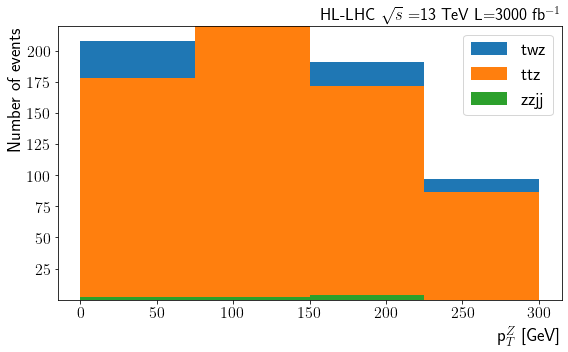

'\nplt.figure()\nhep.histplot(twzDiffXS, bins=bins_ll_pt, yerr=diff_xs_er, xerr=True, stack=True, label=samples, histtype=\'fill\')\nplt.legend(loc=1, ncol=3, fontsize=9)\nplt.xlabel("pt [GeV]")\nplt.ylabel("# events")\n#plt.yscale(\'log\')\nplt.ylim([0.000, 0.015])\nplt.show()\n'

In [47]:
#bin_width = bins_ll_pt[1] - bins_ll_pt[0]
#diff_xs = plot_ll_pt[0]/(intLumi*bin_width)#
#diff_xs_er = (np.sqrt(plot_zpt_diff_xs[0] + plot_zpt_diff_xs[1])) / (BR[isample]*bin_width*(len(z_pt_reco)/30000)*intLumi*1000) 

#print(bin_width)
#print(diff_xs)
#print(diff_xs_er)

#2246

bin_width = bins_z_pt[1] - bins_z_pt[0]

print("reco diff xs twz ")
twzDiffXS = plot_z_pt[2]/(BR[2] *  intLumi *  (2807/30000)   )

print(twzDiffXS)
print(" ")

print("reco abs xs twz ")
print(np.sum(twzDiffXS)* bin_width   )
print(" ")

print("true diff xs twz ")
print(plot_z_pt_true[2]/(BR[2] *  intLumi  * (2807/30000)  ))
print(" ")

totalSig = plot_z_pt[2] 
print("totalSig ")
print(totalSig)

totalBkg = plot_z_pt[0] + plot_z_pt[1] 
print("totalBkg ")
print(totalBkg)

totalBkgUnc = np.sqrt(plot_z_pt[0] + plot_z_pt[1] )

print("rel. unc. xs twz ")
relBkgUnc = ( totalBkgUnc / plot_z_pt[2]  )
print( relBkgUnc )
print(" ")

print("abs. unc. xs twz ")
absBkgUnc = ( relBkgUnc * twzDiffXS  )
print( absBkgUnc)
print(" ")

plt.rcParams['text.usetex'] = True

#s/sqrtb()
#s_sqrt_b = plot_z_pt[2] / ( np.sqrt( plot_z_pt[0] + plot_z_pt[1]  )  )

#plt.figure()
#hep.histplot(s_sqrt_b, bins=bins_z_pt, stack=True, label="", histtype='step')
#plt.legend(loc=1, ncol=1, fontsize=9)
#plt.xlabel("p$^{Z}_{T}$ [GeV]")
#plt.ylabel("Number of events")
#plt.yscale('log')
#plt.ylim([0.1,5])
#plt.show()

#plt.figure()
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
hep.histplot(plot_z_pt, bins=bins_z_pt, stack=True, label=samples, histtype='fill')
hep.cms.lumitext(text=r'HL-LHC $\sqrt{s}=$13 TeV  L=3000 fb$^{-1}$', ax=None, fontname=None, fontsize=18)
plt.legend(loc=1, ncol=1, fontsize=18)
plt.xlabel("p$^{Z}_{T}$ [GeV]", loc="right", fontsize=18)
plt.ylabel("Number of events", loc="top", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.yscale('log')
plt.ylim([0.1, 220])
plt.savefig('4l_expected.pdf')
plt.show()

"""
plt.figure()
hep.histplot(twzDiffXS, bins=bins_ll_pt, yerr=diff_xs_er, xerr=True, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt [GeV]")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.000, 0.015])
plt.show()
"""

In [ ]:
# results from exactly 1 btag

reco diff xs twz 
[34.30543188 40.80810329 19.86642921 10.7524488 ]
 
reco abs xs twz 
7929.9309884013255
 
true diff xs twz 
[508.89804096 539.61932324 263.74220837 123.03873553]
 
totalSig 
[25.358696  30.1654936 14.6853344  7.948248 ]
totalBkg 
[111.75305504 163.21228352 104.6794584   48.7114056 ]
rel. unc. xs twz 
[0.41687206 0.42351226 0.69670174 0.87809989]
 
abs. unc. xs twz 
[14.30097594 17.28273195 13.84097573  9.44172408]

In [15]:
bins_pt_true_mu = np.linspace(0.0, 100.0, num=30)
bins_eta_true_mu = np.linspace(-5.0, 5.0, num=20)
bins_n_true_mu = np.linspace(-0.5, 6.5, num=8)

plot_pt_true_mu = []
plot_eta_true_mu = []
plot_pt_true_e = []
plot_n_true_lep = []

for isample in range(0, len(samples)):
    
    sample_name = str("delphes_output_") + str(samples[isample]) + str("_4l.root")
    eventsData = uproot.open(sample_name)["Delphes"] 
    EventWeight, EventCrossSection, JetPT, JetEta, JetBTag, MuonPT, MuonEta,  MuonPhi,  MuonT, MuonCharge, MuonIsolationVar, MuonDZ, ElectronPT, ElectronEta,  ElectronPhi,  ElectronT, ElectronCharge, ElectronIsolationVar, ParticlePID, ParticleStatus, ParticleMass, ParticlePT, ParticleEta = eventsData.arrays(["Event.Weight", "Event.CrossSection","Jet.PT", "Jet.Eta", "Jet.BTag", "Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.T", "Muon.Charge", "Muon.IsolationVar", "Muon.DZ", "Electron.PT", "Electron.Eta", "Electron.Phi", "Electron.T", "Electron.Charge", "Electron.IsolationVar", "Particle.PID", "Particle.Status","Particle.Mass", "Particle.PT", "Particle.Eta"], outputtype=tuple)
    #eventsData.show()
    
    pt_true_mu = ParticlePT[(abs(ParticlePID)==13) & (abs(ParticleStatus)==1)  & (abs(ParticlePT)>0)]
    pt_true_e = ParticlePT[(abs(ParticlePID)==11) & (abs(ParticleStatus)==1) & (abs(ParticlePT)>0)]
    eta_true_mu = ParticleEta[(abs(ParticlePID)==13) & (abs(ParticleStatus)==1)  & (abs(ParticlePT)>0)]
    n_true_mu = ParticlePT[(abs(ParticlePID)==13) & (abs(ParticleStatus)==1)  & (abs(ParticlePT)>10)].counts
    n_true_e = ParticlePT[(abs(ParticlePID)==11) & (abs(ParticleStatus)==1) & (abs(ParticlePT)>10)].counts
    
    n_true_lep = n_true_mu + n_true_e
    print(n_true_mu)
    print(n_true_e)
    
    H_pt_true_mu, b = np.histogram(pt_true_mu.flatten(), bins=bins_pt_true_mu)
    H_pt_true_e, b = np.histogram(pt_true_e.flatten(), bins=bins_pt_true_mu)
    H_eta_true_mu, b = np.histogram(eta_true_mu.flatten(), bins=bins_eta_true_mu)
    H_n_true_lep, b = np.histogram(n_true_lep, bins=bins_n_true_mu)

    plot_pt_true_mu.append(H_pt_true_mu)
    plot_pt_true_e.append(H_pt_true_e)
    plot_eta_true_mu.append(H_eta_true_mu)
    plot_n_true_lep.append(H_n_true_lep)

plt.figure()
hep.histplot(plot_pt_true_mu, bins=bins_pt_true_mu, stack=False, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt mu")
plt.ylabel("# events")
plt.yscale('log')
plt.ylim([500, 20000])
plt.show()

plt.figure()
hep.histplot(plot_pt_true_e, bins=bins_pt_true_mu, stack=False, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt e")
plt.ylabel("# events")
plt.yscale('log')
plt.ylim([500, 120000])
plt.show()

plt.figure()
hep.histplot(plot_eta_true_mu, bins=bins_eta_true_mu, stack=False, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("eta mu")
plt.ylabel("# events")
plt.yscale('log')
plt.ylim([500, 20000])
plt.show()

plt.figure()
hep.histplot(plot_n_true_lep, bins=bins_n_true_mu, stack=False, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("N lep")
plt.ylabel("# events")
plt.yscale('log')
plt.ylim([500, 20000])
plt.show()

[0 2 2 ... 2 2 3]
[4 2 2 ... 2 2 0]
[3 4 1 ... 4 2 2]
[2 0 2 ... 1 3 2]
[1 2 3 ... 3 1 3]
[3 3 1 ... 2 5 1]


RuntimeError: latex was not able to process the following string:
b'# events'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/Users/jameskeaveney/.matplotlib/tex.cache/7278f9882910cf45d64c0e290af3e0b0.te
x
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 7278f9882910cf45d64c0e290af3e0b0.aux.
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.19 {\sffamily #
                  events}
No pages of output.
Transcript written on 7278f9882910cf45d64c0e290af3e0b0.log.




<Figure size 432x288 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'# events'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/Users/jameskeaveney/.matplotlib/tex.cache/7278f9882910cf45d64c0e290af3e0b0.te
x
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 7278f9882910cf45d64c0e290af3e0b0.aux.
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.19 {\sffamily #
                  events}
No pages of output.
Transcript written on 7278f9882910cf45d64c0e290af3e0b0.log.




<Figure size 432x288 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'# events'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/Users/jameskeaveney/.matplotlib/tex.cache/7278f9882910cf45d64c0e290af3e0b0.te
x
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 7278f9882910cf45d64c0e290af3e0b0.aux.
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.19 {\sffamily #
                  events}
No pages of output.
Transcript written on 7278f9882910cf45d64c0e290af3e0b0.log.




<Figure size 432x288 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'# events'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/Users/jameskeaveney/.matplotlib/tex.cache/7278f9882910cf45d64c0e290af3e0b0.te
x
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 7278f9882910cf45d64c0e290af3e0b0.aux.
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.19 {\sffamily #
                  events}
No pages of output.
Transcript written on 7278f9882910cf45d64c0e290af3e0b0.log.




<Figure size 432x288 with 1 Axes>